# Extract CoM seed point from Segmentation Masks

The FMCIB `get_features` function expects image paths and seed points. If you have segmentations masks you would like to convert to CoM, this notebook provides instructions on how this can be achieved. 

Alternatively, you can use our Mhub https://mhub.ai/models/fmcib_radiomics implementation and use the `nrrd_mask_workflow` as mentioned here: https://github.com/MHubAI/documentation/blob/main/documentation/mhub/run_mhub.md#specify-the-workflow


In [3]:
import subprocess

# Define the input and output file paths
input_file = r"E:\uOttawa\Fall'24 Co-op\Patient 1\1.2.840.113619.2.278.3.2831210243.981.1572215246.359.10489856\totalsegmentator.seg.dcm"
output_file = r"E:\uOttawa\Fall'24 Co-op\Patient 1\1.2.840.113619.2.278.3.2831210243.981.1572215246.359.10489856\totalsegmentator.nii.gz"

# Define the dcm2niix command
command = f"dcm2niix -o {output_file} {input_file}"

# Run the command using subprocess
subprocess.run(command, shell=True)

CompletedProcess(args="dcm2niix -o E:\\uOttawa\\Fall'24 Co-op\\Patient 1\\1.2.840.113619.2.278.3.2831210243.981.1572215246.359.10489856\\totalsegmentator.nii.gz E:\\uOttawa\\Fall'24 Co-op\\Patient 1\\1.2.840.113619.2.278.3.2831210243.981.1572215246.359.10489856\\totalsegmentator.seg.dcm", returncode=1)

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

In [4]:
import SimpleITK as sitk
from fmcib.utils import download_LUNG1, build_image_seed_dict
from fmcib.visualization import visualize_seed_point

First, we download a sample from LUNG1 to show the process of centroid extraction. Use your own data here and skip this step. 

The donwload and conversion will take about a minute. 

In [2]:
download_LUNG1("dummy", samples=1)
build_image_seed_dict("dummy")

2024-08-25 05:44:39.602 | INFO     | fmcib.utils.idc_helper:download_LUNG1:155 - Downloading LUNG1 manifest from Dropbox ...
2024-08-25 05:44:42.712 | INFO     | fmcib.utils.idc_helper:download_from_manifest:99 - Downloading DICOM data from IDC (Imaging Data Commons) ...
100%|██████████| 119/119 [00:03<00:00, 37.52it/s]
2024-08-25 05:44:45.947 | INFO     | fmcib.utils.idc_helper:build_image_seed_dict:264 - Converting DICOM files to NIFTI ...
100%|██████████| 1/1 [00:07<00:00,  7.88s/it]


,image_path,PatientID,coordX,coordY,coordZ
0,E:\uOttawa\Fall'24 Co-op\foundation-cancer-ima...,LUNG1-141,-65.980066,-16.273922,-403.858686


Now we get the path to the image and mask. This can be nii.gz, nrrd, mha or other formats supported by MONAI's ITKReader

In [10]:
import pathlib

dummy_path = pathlib.Path(r"E:\uOttawa\Fall'24 Co-op\Patient 1\_zhangjun1__0227094012\data")
image_path = list(dummy_path.rglob(r"dicom\*.dcm"))[0]
mask_path = list(dummy_path.rglob(r"dicom\*.dcm"))[0]

In [11]:
row = {"image_path": image_path, "label_path": mask_path}

The visualize seed point utility function also visualizes masks when `label_path` is provided as a key in the dict. 

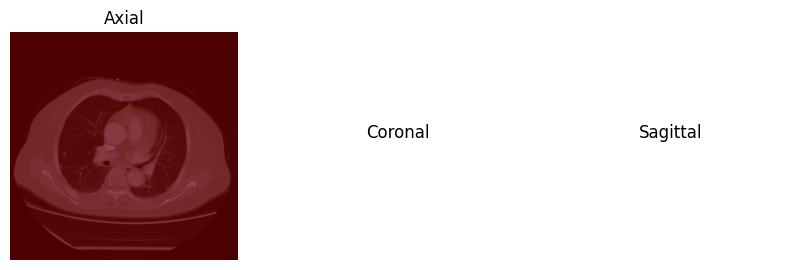

In [12]:
visualize_seed_point(row)

We can now convert the label to centroid coordinates (in the physical space). For this we,
1. Load the mask using SimpleITK
2. Use SimpleITK `LabelShapeStatisticsImageFilter` to get the centroid

In [13]:
mask = sitk.ReadImage(mask_path)

# get the center of massk from the mask via ITK
label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
label_shape_filter.Execute(mask)
try:
    centroid = label_shape_filter.GetCentroid(255)
except RuntimeError:
    centroid = label_shape_filter.GetCentroid(1)

# extract x, y, and z coordinates from the centroid
x, y, z = centroid

# set up the coordinate dictionary
coordinate_dict = {
    "coordX": x,
    "coordY": y,
    "coordZ": z,
}

In [14]:
coordinate_dict

{'coordX': -11.947617574257407, 'coordY': 25.973855198019805, 'coordZ': -143.5}

In [15]:
row = {"image_path": image_path, **coordinate_dict}

Now we can call the visualize seed point function again but this time with the `image_path` and coordinate values

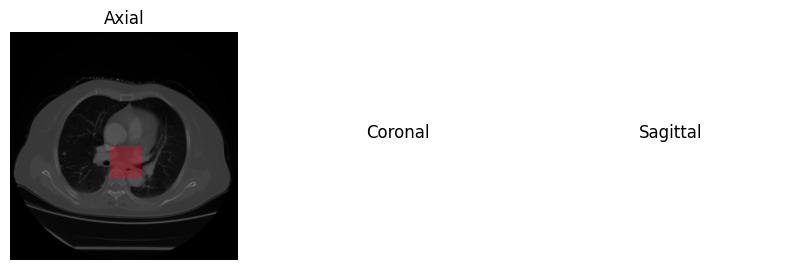

In [16]:
visualize_seed_point(row)

The bounding box that will be passed to FMCIB centered around the seed point is now seen. 

In [17]:
import pathlib
import SimpleITK as sitk
import csv

# Define the directory containing the images
image_dir = pathlib.Path(r"E:\\uOttawa\\Fall'24 Co-op\\Patient 1\\_zhangjun1__0227094012\\data")

# Initialize an empty list to store the results
results = []

# Iterate through each image in the directory
for image_path in image_dir.rglob(r"dicom\\*.dcm"):
    try:
        # Load the mask using SimpleITK
        mask = sitk.ReadImage(str(image_path)) #Since there is no predetermined segmentation mask, we will use the image itself as the mask
        
        # Extract the centroid coordinates using LabelShapeStatisticsImageFilter
        label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
        label_shape_filter.Execute(mask)
        
        try:
            centroid = label_shape_filter.GetCentroid(255)
        except:
            centroid = label_shape_filter.GetCentroid(1)
        
        # Extract x, y, and z coordinates from the centroid
        x, y, z = centroid
        
        # Append the image path and coordinates to the results list
        results.append({
            "image_path": str(image_path),
            "coordX": x,
            "coordY": y,
            "coordZ": z
        })
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Define the output CSV file path
output_csv = r"E:\\uOttawa\\Fall'24 Co-op\\Patient 1\\centroid_coordinates.csv"

# Write the results list to a CSV file
with open(output_csv, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["image_path", "coordX", "coordY", "coordZ"])
    writer.writeheader()
    writer.writerows(results)

print(f"Centroid coordinates saved to {output_csv}")

Centroid coordinates saved to E:\\uOttawa\\Fall'24 Co-op\\Patient 1\\centroid_coordinates.csv
